### Import Libraries

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
import rioxarray as rioxr
from shapely import box

import pystac_client
import planetary_computer

from IPython.display import Image 

### Import Arizona Shapefile

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

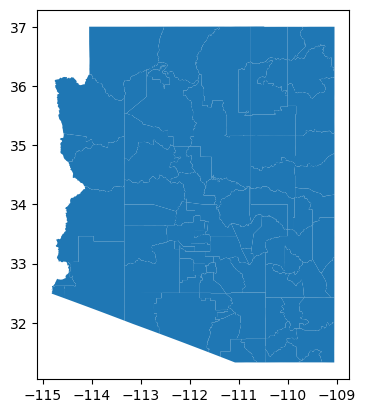

In [ ]:
# Import Shapefile for Arizona
arizona = gpd.read_file(os.path.join('data',
                                'tl_2020_04_cousub',   
                                'tl_2020_04_cousub.shp'))

arizona.plot()
arizona.crs

# Use Catalog Search to Grab Data
Connect to the Microsoft Planetary Computer data catalog and perform the search. The collection ID for Biodiversity Intactness Index (Bll) Time Series data is `io-biodiversity`. This uses the 2017 - 2020 Rasters covering the Phoenix subdivision.

In [ ]:
# Open MPC data catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Set Bounding Box Coordinates
bbox_of_interest = [-112.826843, 32.974108, -111.184387, 33.863574]

# Search MPC Datalog
search = catalog.search(collections=["io-biodiversity"], bbox=bbox_of_interest)


# Retrieve Search Items
items = search.item_collection()
print(f'Returned{len(items)} items')

items

Returned4 items


In [16]:
# Select unique search item
item = items[0]  

# Display pre-rendered image
Image(url=item.assets['rendered_preview'].href, width=600)

In [6]:
# Access Raster Data from item
lulc = rioxr.open_rasterio(item.assets['data'].href)

lulc

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

Notice that 'band' is dimension of length 1. We can go ahead and "squeeze" the raster to simplify it:

In [7]:
# Remove Length 1 dimension (band)

lulc = lulc.squeeze().drop_vars('band')

print("Size of dimension:", dict(lulc.sizes))

Size of dimension: {'y': 7992, 'x': 7992}


In [8]:
# Viewing bounding box
lulc.rio.bounds()

(-115.38597824385106,
 27.56531399453427,
 -108.20664249316783,
 34.74464974521749)

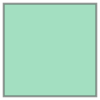

In [9]:
box(*lulc.rio.bounds())

In [10]:
# Create GeoDataFrame from raster bounary box
lulc_bbox = gpd.GeoDataFrame(geometry= [box(*lulc.rio.bounds())],
                             crs = lulc.rio.crs)

lulc_bbox

,geometry
0,"POLYGON ((-108.20664 27.56531, -108.20664 34.7..."


<Axes: >

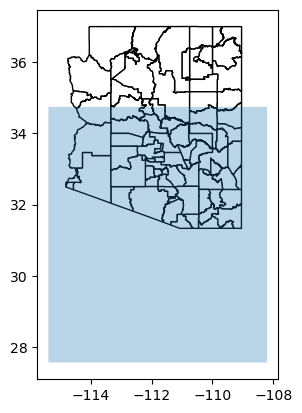

In [20]:
#Plot raster boundary, lulc, and arizona boundary

fig,ax = plt.subplots()

arizona.plot(ax=ax, color='white', edgecolor='black')

# Reproject all other data to match CA CRS
lulc_bbox.to_crs(arizona.crs).plot(ax=ax, alpha=0.3)
